# POC : Analyse de scènes routières - Données Volvo

## Objectif

Démontrer qu'on peut faire des **analyses simples et pédagogiques** avec les données LiDAR Volvo **sans traiter les nuages de points 3D** !

**Données utilisées** : Annotations JSON (bounding boxes 3D)

**Niveau** : Débutant (juste Pandas)

---

## Étape 1 : Charger les données depuis GCS

On va lire les fichiers JSON d'annotations directement depuis le bucket GCS.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import storage
import subprocess

# Configuration
plt.style.use('seaborn-v0_8')
%matplotlib inline

print("✅ Bibliothèques importées")

✅ Bibliothèques importées


In [2]:
np.version.version

'1.26.4'

In [3]:
print(np.__version__)

1.26.4


In [4]:
# Fonction pour lire JSON depuis GCS
def load_json_from_gcs(uri):
    """Charge un fichier JSON depuis Google Cloud Storage"""
    result = subprocess.run(
        ["gsutil", "cat", uri],
        capture_output=True,
        text=True
    )
    return json.loads(result.stdout)

# Lister les fichiers JSON disponibles
def list_json_files(bucket_path):
    """Liste tous les fichiers JSON dans un dossier GCS"""
    result = subprocess.run(
        ["gsutil", "ls", f"{bucket_path}*.json"],
        capture_output=True,
        text=True
    )
    return [line for line in result.stdout.strip().split('\n') if line]

print("✅ Fonctions utilitaires définies")

✅ Fonctions utilitaires définies


In [5]:
# Lister tous les fichiers JSON des datasets disponibles
datasets = ['dataset4', 'dataset6']  # Datasets avec annotations
json_files = []

print("📊 Chargement des scènes depuis tous les datasets disponibles...\n")

for dataset in datasets:
    bucket_path = f"gs://big_data_ai_course/Cirrus_{dataset}/{dataset}_annotation/"
    files = list_json_files(bucket_path)
    json_files.extend(files)
    print(f"  - {dataset}: {len(files)} scène(s)")

print(f"\n✅ Total: {len(json_files)} scènes disponibles")
print(f"\nExemples de fichiers:")
for f in json_files[:5]:
    print(f"  - {f}")

📊 Chargement des scènes depuis tous les datasets disponibles...

  - dataset4: 2 scène(s)
  - dataset6: 3 scène(s)

✅ Total: 5 scènes disponibles

Exemples de fichiers:
  - gs://big_data_ai_course/Cirrus_dataset4/dataset4_annotation/1558133069247038622.json
  - gs://big_data_ai_course/Cirrus_dataset4/dataset4_annotation/1558133481055433883.json
  - gs://big_data_ai_course/Cirrus_dataset6/dataset6_annotation/1558135935813209837.json
  - gs://big_data_ai_course/Cirrus_dataset6/dataset6_annotation/1558136094815223569.json
  - gs://big_data_ai_course/Cirrus_dataset6/dataset6_annotation/1558136193821994093.json


---
## Étape 2 : Charger et parser une scène exemple

Regardons à quoi ressemble une scène.

In [6]:
# Charger une scène exemple
sample_scene = load_json_from_gcs(json_files[0])

print("🔍 Contenu d'une scène:\n")
print(json.dumps(sample_scene, indent=2)[:1000] + "...")

🔍 Contenu d'une scène:

{
  "timestamp": 1558133069247038622,
  "label_type": "bounding_boxes_3d",
  "file_paths": {
    "camera": "dataset/raw_data/camera/1558133069247038622.jpg",
    "lidar": "dataset/raw_data/lidar/1558133069247038622.xyz"
  },
  "labels": [
    {
      "id": 8826,
      "position": [
        60.10903105864577,
        3.8973652380654173,
        -1.3577849406299034
      ],
      "size": [
        3.7604710205649194,
        1.825448316254794,
        1.2495994010842062
      ],
      "quaternion": [
        -0.00016998184782471016,
        0.010934175827099433,
        -0.01526596953144451,
        0.9998236669930446
      ],
      "label_class": "vehicle"
    },
    {
      "id": 7734,
      "position": [
        35.665271386464156,
        4.251768721431201,
        -0.8118305350630806
      ],
      "size": [
        4.741086987534096,
        2.318531503535571,
        2.074112527858957
      ],
      "quaternion": [
        -0.00015108062203997,
        0.00

In [7]:
# Extraire les informations clés
timestamp = sample_scene['timestamp']
labels = sample_scene['labels']

print(f"📅 Timestamp: {timestamp}")
print(f"🚗 Nombre de véhicules détectés: {len(labels)}")
print(f"\n🏷️  Premier véhicule:")
print(json.dumps(labels[0], indent=2))

📅 Timestamp: 1558133069247038622
🚗 Nombre de véhicules détectés: 19

🏷️  Premier véhicule:
{
  "id": 8826,
  "position": [
    60.10903105864577,
    3.8973652380654173,
    -1.3577849406299034
  ],
  "size": [
    3.7604710205649194,
    1.825448316254794,
    1.2495994010842062
  ],
  "quaternion": [
    -0.00016998184782471016,
    0.010934175827099433,
    -0.01526596953144451,
    0.9998236669930446
  ],
  "label_class": "vehicle"
}


**💡 Ce qu'on peut voir :**

- `position` : [x, y, z] coordonnées du véhicule
- `size` : [longueur, largeur, hauteur] dimensions
- `label_class` : type d'objet (vehicle, pedestrian, etc.)
- `quaternion` : orientation 3D (on peut l'ignorer pour simplifier)

**Ce qu'on va faire :**
- Analyser la **distance** des véhicules (position x, y)
- Compter le **nombre de véhicules** par scène
- Analyser la **densité du trafic**

---
## Étape 3 : Extraire features de toutes les scènes

Créons un dataset avec des features simples par scène.

In [8]:
len(labels)

19

In [9]:
def extract_scene_features(scene_data, dataset_id=None):
    """
    Extrait des features simples d'une scène.
    Retourne un dictionnaire avec les métriques clés.
    """
    labels = scene_data['labels']

    # Nombre de véhicules
    num_vehicles = len(labels)

    if num_vehicles == 0:
        return {
            'dataset_id': dataset_id,
            'timestamp': scene_data['timestamp'],
            'num_vehicles': 0,
            'avg_distance': 0.0,
            'min_distance': 0.0,
            'max_distance': 0.0,
            'std_distance': 0.0,
            'avg_x': 0.0,
            'avg_y': 0.0,
            'spread_x': 0.0,
            'spread_y': 0.0
        }

    # Extraire positions
    positions = [label['position'] for label in labels]
    x_coords = [pos[0] for pos in positions]
    y_coords = [pos[1] for pos in positions]

    # Calculer distances par rapport à l'origine (véhicule ego)
    distances = [np.sqrt(pos[0]**2 + pos[1]**2) for pos in positions]

    # Features - convertir explicitement en types Python natifs
    features = {
        'dataset_id': dataset_id,
        'timestamp': scene_data['timestamp'],
        'num_vehicles': int(num_vehicles),
        'avg_distance': float(np.mean(distances)),
        'min_distance': float(np.min(distances)),
        'max_distance': float(np.max(distances)),
        'std_distance': float(np.std(distances)),
        'avg_x': float(np.mean(x_coords)),
        'avg_y': float(np.mean(y_coords)),
        'spread_x': float(np.std(x_coords)),
        'spread_y': float(np.std(y_coords))
    }

    return features

print("✅ Fonction extract_scene_features définie")

✅ Fonction extract_scene_features définie


In [10]:
# Test sur la scène exemple
test_features = extract_scene_features(sample_scene)

print("✅ Features extraites pour une scène exemple:\n")
for key, value in test_features.items():
    if isinstance(value, float):
        print(f"   {key}: {value:.2f}")
    else:
        print(f"   {key}: {value}")

✅ Features extraites pour une scène exemple:

   dataset_id: None
   timestamp: 1558133069247038622
   num_vehicles: 19
   avg_distance: 83.25
   min_distance: 5.32
   max_distance: 237.74
   std_distance: 56.97
   avg_x: 79.22
   avg_y: 16.93
   spread_x: 58.23
   spread_y: 14.95


In [11]:
min(50, len(json_files))

5

In [12]:
# Extraire features de toutes les scènes disponibles
print("🔄 Extraction des features de toutes les scènes...\n")

all_features = []
max_scenes = min(100, len(json_files))  # Limiter à 100 ou au nombre disponible

for i, json_file in enumerate(json_files[:max_scenes]):
    try:
        # Extraire le dataset_id du chemin du fichier
        dataset_id = 'dataset4' if 'dataset4' in json_file else 'dataset6'

        scene = load_json_from_gcs(json_file)
        features = extract_scene_features(scene, dataset_id=dataset_id)
        all_features.append(features)

        if (i + 1) % 10 == 0 or (i + 1) == len(json_files[:max_scenes]):
            print(f"   Traité {i + 1}/{max_scenes} scènes...")
    except Exception as e:
        print(f"   ⚠️ Erreur sur {json_file}: {e}")

print(f"\n✅ Total: {len(all_features)} scènes traitées")

🔄 Extraction des features de toutes les scènes...

   Traité 5/5 scènes...

✅ Total: 5 scènes traitées


In [13]:
# Créer DataFrame
if len(all_features) == 0:
    print("⚠️ Aucune feature extraite, impossible de créer le DataFrame")
else:
    # Convertir en DataFrame de façon plus robuste
    # Créer le DataFrame colonne par colonne pour éviter les problèmes de conversion
    df_scenes = pd.DataFrame({
        'dataset_id': [f['dataset_id'] for f in all_features],
        'timestamp': [f['timestamp'] for f in all_features],
        'num_vehicles': [f['num_vehicles'] for f in all_features],
        'avg_distance': [f['avg_distance'] for f in all_features],
        'min_distance': [f['min_distance'] for f in all_features],
        'max_distance': [f['max_distance'] for f in all_features],
        'std_distance': [f['std_distance'] for f in all_features],
        'avg_x': [f['avg_x'] for f in all_features],
        'avg_y': [f['avg_y'] for f in all_features],
        'spread_x': [f['spread_x'] for f in all_features],
        'spread_y': [f['spread_y'] for f in all_features]
    })

    print(f"✅ Dataset créé: {df_scenes.shape[0]} scènes, {df_scenes.shape[1]} features\n")
    print(f"📊 Répartition par dataset:")
    print(df_scenes['dataset_id'].value_counts())
    print(f"\n💡 Aperçu des données:")
    display(df_scenes.head())

✅ Dataset créé: 5 scènes, 11 features

📊 Répartition par dataset:
dataset_id
dataset6    3
dataset4    2
Name: count, dtype: int64

💡 Aperçu des données:


,dataset_id,timestamp,num_vehicles,avg_distance,min_distance,max_distance,std_distance,avg_x,avg_y,spread_x,spread_y
0,dataset4,1558133069247038622,19,83.250103,5.320511,237.735560,56.968924,79.217287,16.927004,58.230337,14.945360
1,dataset4,1558133481055433883,12,57.819010,9.571897,137.773386,33.788440,57.091162,-6.287337,33.782253,6.672672
2,dataset6,1558135935813209837,24,60.088084,7.937519,182.281191,46.899825,58.562376,5.170154,47.604244,9.366158
3,dataset6,1558136094815223569,32,60.049117,8.055385,152.903979,40.269119,56.338279,-8.011243,42.394354,13.857689
4,dataset6,1558136193821994093,15,61.605254,9.603284,119.642472,35.992738,59.378788,2.352517,34.159089,19.810766


---
## Étape 4 : Analyses exploratoires

### 4.1 Distribution du nombre de véhicules

In [14]:
# Statistiques descriptives
print("📊 Statistiques descriptives:\n")
print(df_scenes.describe().round(2))

📊 Statistiques descriptives:

          timestamp  num_vehicles  avg_distance  min_distance  max_distance  \
count  5.000000e+00          5.00          5.00          5.00          5.00   
mean   1.558135e+18         20.40         64.56          8.10        166.07   
std    1.543084e+12          7.89         10.53          1.75         46.17   
min    1.558133e+18         12.00         57.82          5.32        119.64   
25%    1.558133e+18         15.00         60.05          7.94        137.77   
50%    1.558136e+18         19.00         60.09          8.06        152.90   
75%    1.558136e+18         24.00         61.61          9.57        182.28   
max    1.558136e+18         32.00         83.25          9.60        237.74   

       std_distance  avg_x  avg_y  spread_x  spread_y  
count          5.00   5.00   5.00      5.00      5.00  
mean          42.78  62.12   2.03     43.23     12.93  
std            9.37   9.63  10.02     10.20      5.10  
min           33.79  56.34  -8.01 

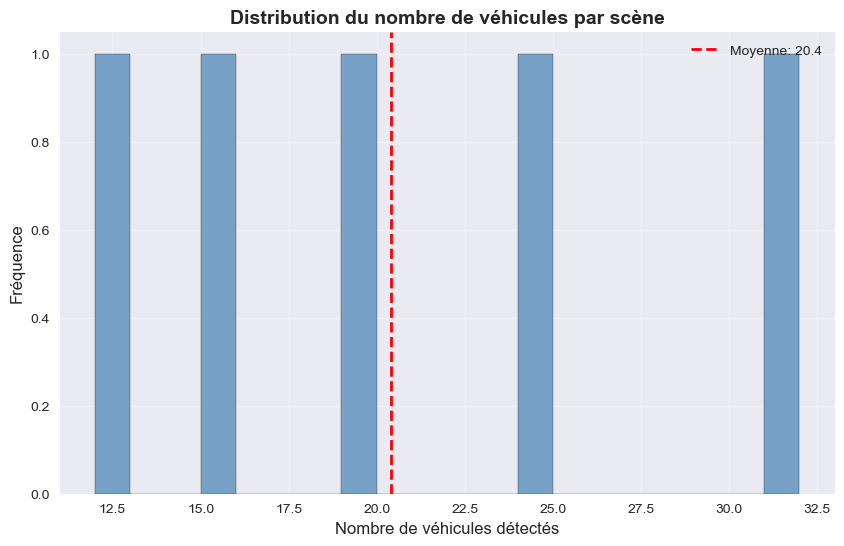


📈 Nombre moyen de véhicules: 20.40
📈 Min: 12, Max: 32


In [15]:
# Histogramme nombre de véhicules
plt.figure(figsize=(10, 6))
plt.hist(df_scenes['num_vehicles'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Nombre de véhicules détectés', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.title('Distribution du nombre de véhicules par scène', fontsize=14, fontweight='bold')
plt.axvline(df_scenes['num_vehicles'].mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {df_scenes["num_vehicles"].mean():.1f}')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"\n📈 Nombre moyen de véhicules: {df_scenes['num_vehicles'].mean():.2f}")
print(f"📈 Min: {df_scenes['num_vehicles'].min()}, Max: {df_scenes['num_vehicles'].max()}")

### 4.2 Distribution des distances

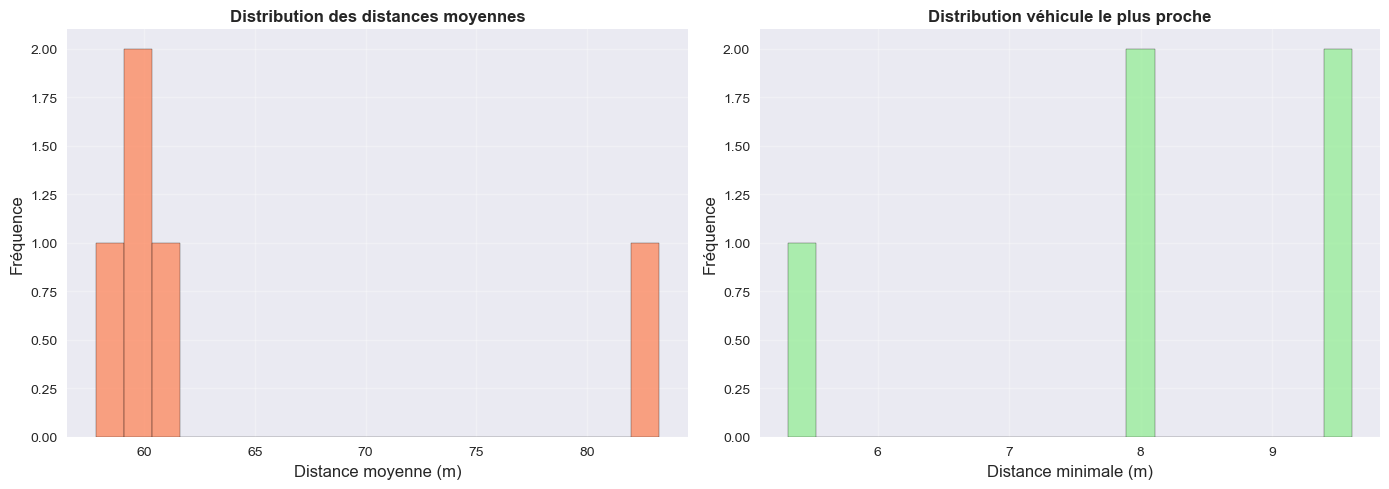


🚗 Distance moyenne des véhicules: 64.56m
🚗 Véhicule le plus proche (moyenne): 8.10m


In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Distance moyenne
ax1.hist(df_scenes['avg_distance'], bins=20, edgecolor='black', alpha=0.7, color='coral')
ax1.set_xlabel('Distance moyenne (m)', fontsize=12)
ax1.set_ylabel('Fréquence', fontsize=12)
ax1.set_title('Distribution des distances moyennes', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3)

# Distance min (véhicule le plus proche)
ax2.hist(df_scenes['min_distance'], bins=20, edgecolor='black', alpha=0.7, color='lightgreen')
ax2.set_xlabel('Distance minimale (m)', fontsize=12)
ax2.set_ylabel('Fréquence', fontsize=12)
ax2.set_title('Distribution véhicule le plus proche', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🚗 Distance moyenne des véhicules: {df_scenes['avg_distance'].mean():.2f}m")
print(f"🚗 Véhicule le plus proche (moyenne): {df_scenes['min_distance'].mean():.2f}m")

### 4.3 Relation nombre de véhicules vs distance

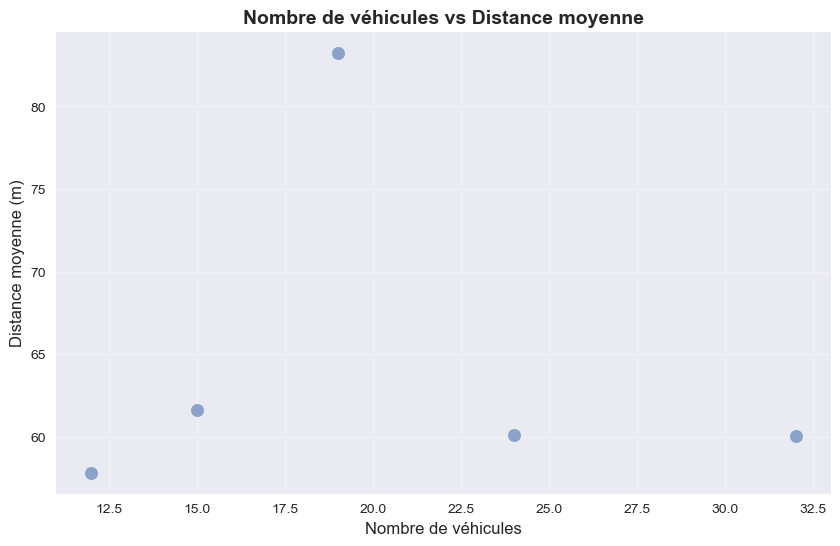


📊 Corrélation: -0.066
⚠️ Pas de corrélation claire


In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(df_scenes['num_vehicles'], df_scenes['avg_distance'], alpha=0.6, s=80)
plt.xlabel('Nombre de véhicules', fontsize=12)
plt.ylabel('Distance moyenne (m)', fontsize=12)
plt.title('Nombre de véhicules vs Distance moyenne', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.show()

# Corrélation
corr = df_scenes['num_vehicles'].corr(df_scenes['avg_distance'])
print(f"\n📊 Corrélation: {corr:.3f}")
if corr > 0.3:
    print("✅ Plus il y a de véhicules, plus la distance moyenne augmente (dispersion)")
elif corr < -0.3:
    print("✅ Plus il y a de véhicules, plus ils sont proches (trafic dense)")
else:
    print("⚠️ Pas de corrélation claire")

---
## Étape 5 : Clustering simple des scènes

Segmentons les scènes en groupes (trafic dense, fluide, etc.)

In [18]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Sélectionner features pour clustering
features_for_clustering = ['num_vehicles', 'avg_distance', 'spread_x', 'spread_y']

X = df_scenes[features_for_clustering]

# Déterminer le nombre optimal de clusters (max 3, ou moins si peu de données)
n_clusters = min(3, len(df_scenes))

if n_clusters < 2:
    print("⚠️ Pas assez de scènes pour faire du clustering (minimum 2 scènes requises)")
    df_scenes['cluster'] = 0
else:
    # Normalisation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df_scenes['cluster'] = kmeans.fit_predict(X_scaled)

    print(f"✅ Clustering effectué avec {n_clusters} clusters")
    print(f"\n📊 Distribution des clusters:")
    print(df_scenes['cluster'].value_counts())

✅ Clustering effectué avec 3 clusters

📊 Distribution des clusters:
cluster
0    2
1    2
2    1
Name: count, dtype: int64


In [19]:
kmeans

,n_clusters,3
,init,'k-means++'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [20]:
X_scaled

array([[-0.19830744,  1.98349422,  1.64331845,  0.44152125],
       [-1.18984467, -0.71572428, -1.0357448 , -1.37131958],
       [ 0.50993343, -0.47488812,  0.47889284, -0.78108066],
       [ 1.64311883, -0.47902395, -0.09201594,  0.20317377],
       [-0.76490014, -0.31385787, -0.99445055,  1.50770522]])

In [21]:
kmeans.fit_predict(X_scaled)

array([2, 0, 1, 1, 0], dtype=int32)

In [22]:
df_scenes['cluster'] = kmeans.fit_predict(X_scaled)

In [23]:
    print(f"✅ Clustering effectué avec {n_clusters} clusters")
    print(f"\n📊 Distribution des clusters:")
    print(df_scenes['cluster'].value_counts())

✅ Clustering effectué avec 3 clusters

📊 Distribution des clusters:
cluster
0    2
1    2
2    1
Name: count, dtype: int64


In [24]:
X

,num_vehicles,avg_distance,spread_x,spread_y
0,19,83.250103,58.230337,14.945360
1,12,57.819010,33.782253,6.672672
2,24,60.088084,47.604244,9.366158
3,32,60.049117,42.394354,13.857689
4,15,61.605254,34.159089,19.810766


In [25]:
n_clusters

3

In [26]:
df_scenes.columns

Index(['dataset_id', 'timestamp', 'num_vehicles', 'avg_distance',
       'min_distance', 'max_distance', 'std_distance', 'avg_x', 'avg_y',
       'spread_x', 'spread_y', 'cluster'],
      dtype='object')

In [27]:
# Profils des clusters
print("\n📊 Profils moyens par cluster:\n")
cluster_profiles = df_scenes.groupby('cluster')[features_for_clustering].mean()
print(cluster_profiles.round(2))


📊 Profils moyens par cluster:

         num_vehicles  avg_distance  spread_x  spread_y
cluster                                                
0                13.5         59.71     33.97     13.24
1                28.0         60.07     45.00     11.61
2                19.0         83.25     58.23     14.95


In [28]:
df_scenes.columns

Index(['dataset_id', 'timestamp', 'num_vehicles', 'avg_distance',
       'min_distance', 'max_distance', 'std_distance', 'avg_x', 'avg_y',
       'spread_x', 'spread_y', 'cluster'],
      dtype='object')

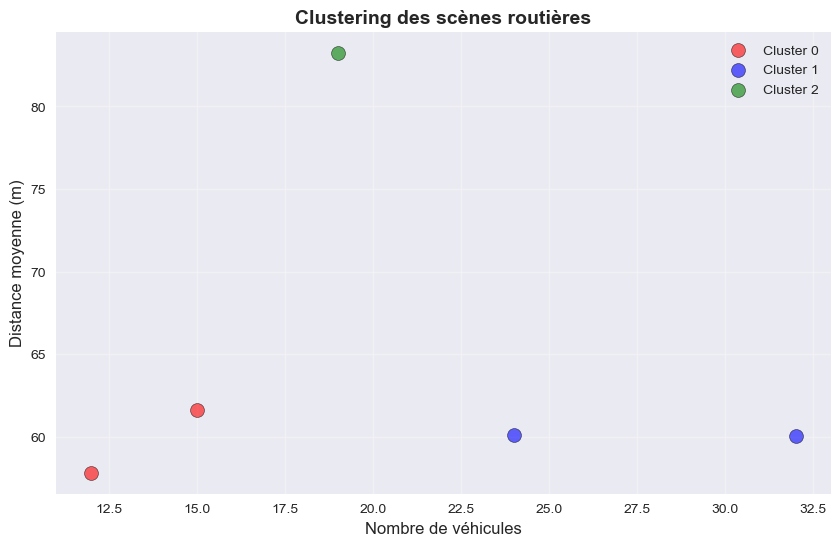

In [29]:
# Visualisation
if 'cluster' not in df_scenes.columns:
    print("⚠️ Veuillez exécuter la cellule de clustering (cellule ci-dessus) avant de visualiser les résultats.")
else:
    plt.figure(figsize=(10, 6))
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    unique_clusters = sorted(df_scenes['cluster'].unique())

    for cluster_id in unique_clusters:
        mask = df_scenes['cluster'] == cluster_id
        plt.scatter(df_scenes[mask]['num_vehicles'],
                    df_scenes[mask]['avg_distance'],
                    c=colors[cluster_id % len(colors)],
                    label=f'Cluster {cluster_id}',
                    alpha=0.6, s=100, edgecolors='black', linewidth=0.5)

    plt.xlabel('Nombre de véhicules', fontsize=12)
    plt.ylabel('Distance moyenne (m)', fontsize=12)
    plt.title('Clustering des scènes routières', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

**💡 Interprétation des clusters :**

En regardant les profils moyens, on peut nommer les clusters :
- **Cluster avec peu de véhicules + grandes distances** → Trafic fluide / Autoroute
- **Cluster avec beaucoup de véhicules + distances moyennes** → Trafic dense / Urbain
- **Cluster intermédiaire** → Trafic modéré

---
## Conclusion du POC

### ✅ Ce qu'on a démontré :

1. **Pas besoin de traiter les nuages de points 3D** !
2. Les **annotations JSON sont suffisantes** pour des analyses intéressantes
3. On peut faire du **clustering**, de la **détection d'anomalies**, etc.
4. **Niveau débutant** : juste Pandas, scikit-learn
5. **Lien métier** : analyse de scènes routières (perception véhicules)

### 🎯 Applications pour la formation :

**Jour 1 - Exploration données :**
- Charger et parser JSON
- Extraire features simples
- Visualisations de base

**Jour 2 - Machine Learning :**
- Clustering de scènes (K-Means)
- Détection d'anomalies (scènes inhabituelles)
- Prédiction densité trafic

### 📊 Datasets complémentaires recommandés :

Pour avoir aussi de la **maintenance prédictive** (plus proche calculateurs) :
- **YunSolutions LEVIN** : données OBD-II classiques
- OU générer des données synthétiques de pannes

---

**Prochaine étape** : Adapter les 3 notebooks complets avec cette approche ?